In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [2]:
# Load the dataset
data = pd.read_csv('feynn_t3.csv')

# Convert the Order Date to datetime format
data['Order Date'] = pd.to_datetime(data['Order Date'])

# Set the Order Date as the index
data.set_index('Order Date', inplace=True)

# Explore the data
print(data.head())
print(data.info())
print(data.describe())

            Row ID        Order ID   Ship Date       Ship Mode Customer ID  \
Order Date                                                                   
2017-08-11       1  CA-2017-152156  11/11/2017    Second Class    CG-12520   
2017-08-11       2  CA-2017-152156  11/11/2017    Second Class    CG-12520   
2017-12-06       3  CA-2017-138688  16/06/2017    Second Class    DV-13045   
2016-11-10       4  US-2016-108966  18/10/2016  Standard Class    SO-20335   
2016-11-10       5  US-2016-108966  18/10/2016  Standard Class    SO-20335   

              Customer Name    Segment        Country             City  \
Order Date                                                               
2017-08-11      Claire Gute   Consumer  United States        Henderson   
2017-08-11      Claire Gute   Consumer  United States        Henderson   
2017-12-06  Darrin Van Huff  Corporate  United States      Los Angeles   
2016-11-10   Sean O'Donnell   Consumer  United States  Fort Lauderdale   
2016-11-1

C:\Users\shres\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '15/04/2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\shres\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '22/11/2016' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\shres\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '13/05/2015' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
C:\Users\shres\anaconda3\lib\site-packages\pandas\core\tools\datetimes.py:1047: UserWarning: Parsing '27/08/2015' in DD/MM/YYYY format. Provide format or specif

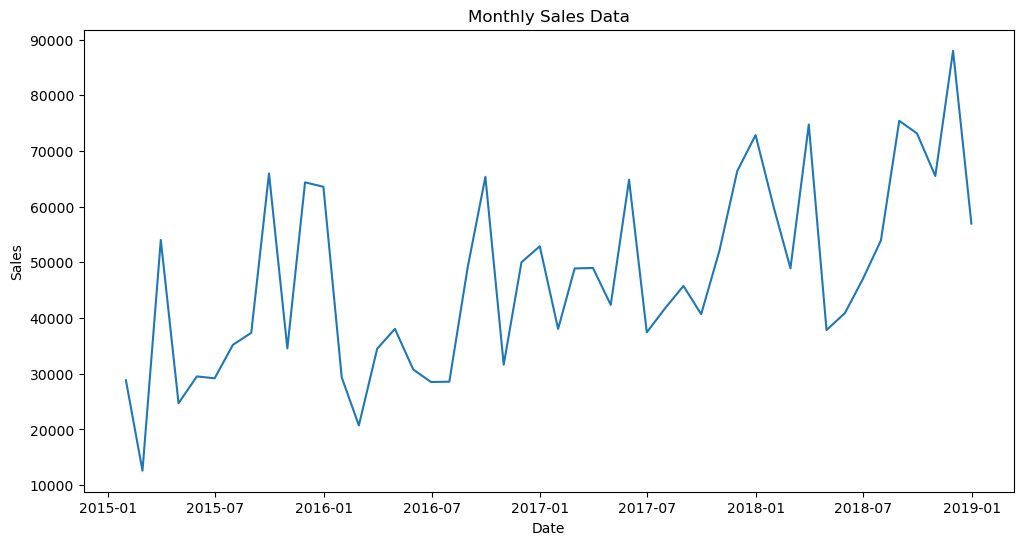

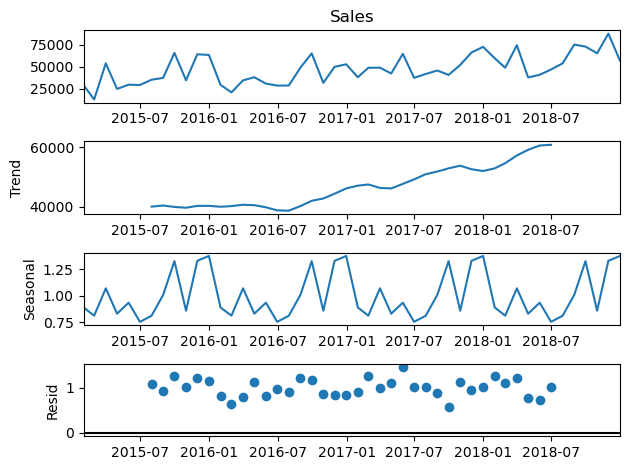

In [3]:
# Resample data to monthly frequency
monthly_data = data['Sales'].resample('M').sum()

# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(monthly_data)
plt.title('Monthly Sales Data')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Decompose the time series to visualize trend, seasonality, and residuals
decomposition = seasonal_decompose(monthly_data, model='multiplicative')
decomposition.plot()
plt.show()

In [4]:
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

adf_test(monthly_data)

ADF Statistic: -1.1450819586604941
p-value: 0.6967631967119422
Critical Values: {'1%': -3.6055648906249997, '5%': -2.937069375, '10%': -2.606985625}


In [5]:
# First-order differencing
monthly_data_diff = monthly_data.diff().dropna()

# Perform ADF test on differenced data
adf_test(monthly_data_diff)

ADF Statistic: -3.977546392195676
p-value: 0.0015327578233736367
Critical Values: {'1%': -3.626651907578875, '5%': -2.9459512825788754, '10%': -2.6116707716049383}


C:\Users\shres\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


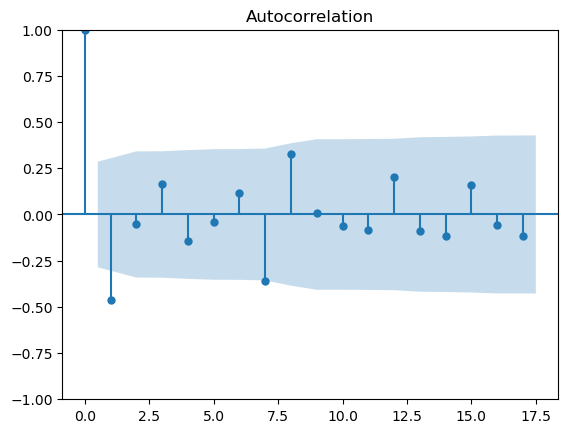

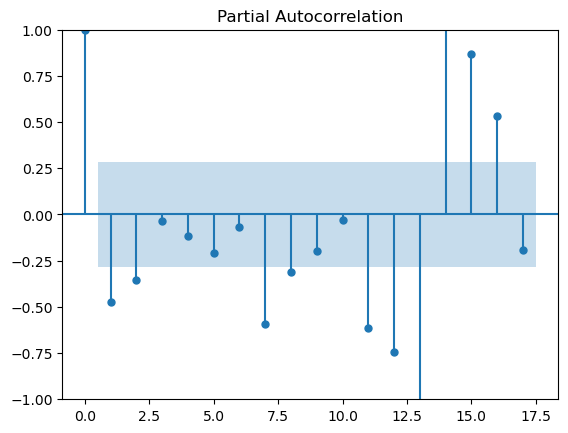

In [6]:
plot_acf(monthly_data_diff)
plot_pacf(monthly_data_diff)
plt.show()

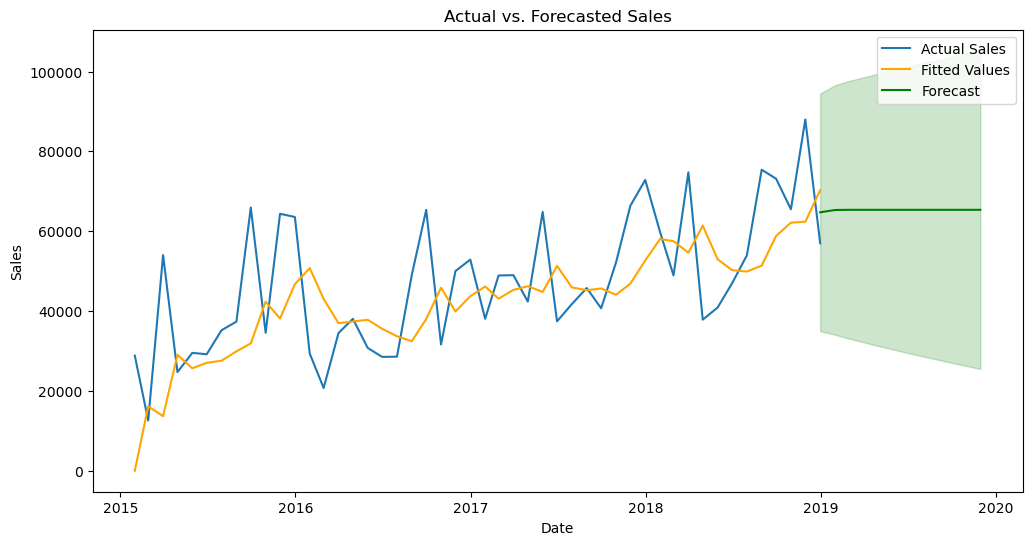

Mean Squared Error: 246089526.30772445


In [10]:
order = (1, 1, 1)  # Example order (p, d, q)
model = ARIMA(monthly_data, order=order)
fit_model = model.fit()

# Forecast
forecast_steps = 12  # Number of months to forecast
forecast = fit_model.get_forecast(steps=forecast_steps)

# Extract forecasted values and confidence intervals
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot actual vs. forecasted sales
plt.figure(figsize=(12, 6))
plt.plot(monthly_data, label='Actual Sales')
plt.plot(fit_model.fittedvalues, label='Fitted Values', color='orange')
plt.plot(pd.date_range(start=monthly_data.index[-1], periods=forecast_steps, freq='M'), forecast_values, label='Forecast', color='green')
plt.fill_between(pd.date_range(start=monthly_data.index[-1], periods=forecast_steps, freq='M'), conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='green', alpha=0.2)
plt.title('Actual vs. Forecasted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(monthly_data[-forecast_steps:], forecast_values)
print('Mean Squared Error:', mse)